In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset shape: (2042, 80)

First few rows:
  ClientID  CycleNumber  Group  CycleWithPeakorNot  ReproductiveCategory  \
0  nfp8122            1      0                   1                     0   
1  nfp8122            2      0                   1                     0   
2  nfp8122            3      0                   1                     0   
3  nfp8122            4      0                   1                     0   
4  nfp8122            5      0                   1                     0   

   LengthofCycle  MeanCycleLength  EstimatedDayofOvulation  \
0             29            27.33                     17.0   
1             27             0.00                     15.0   
2             29             0.00                     15.0   
3             27             0.00                     15.0   
4             28             0.00                     16.0   

   LengthofLutealPhase FirstDayofHigh  ...  Method  Prevmethod  Methoddate  \
0                 12.0             12  ...       

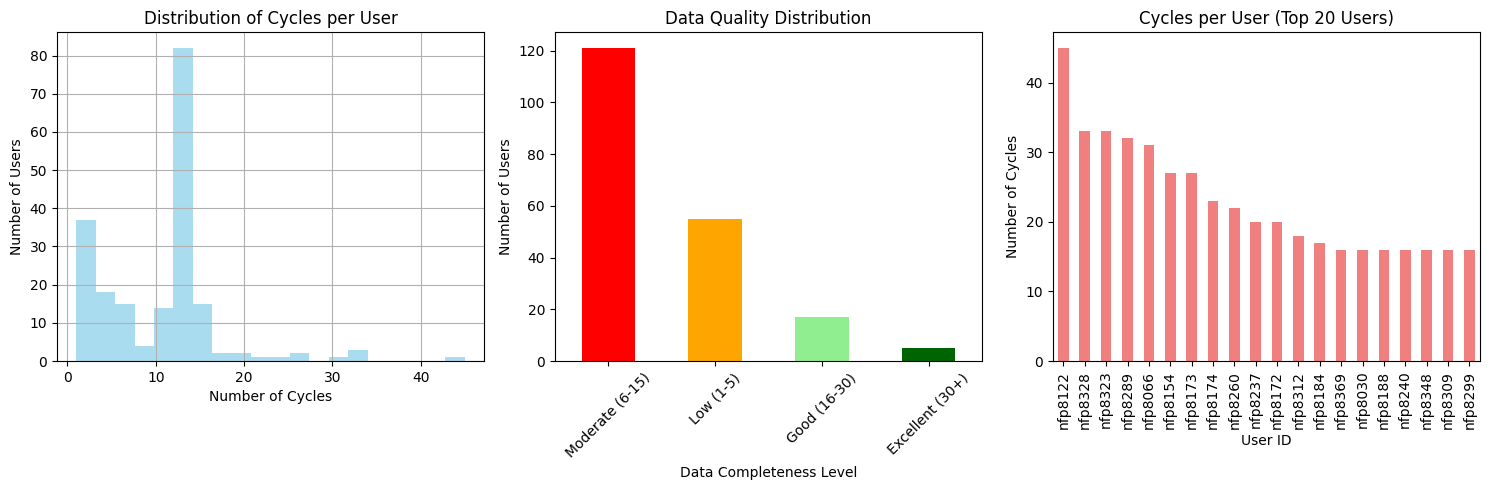


Data completeness categories:
  Moderate (6-15): 121 users (61.1%)
  Low (1-5): 55 users (27.8%)
  Good (16-30): 17 users (8.6%)
  Excellent (30+): 5 users (2.5%)

Missing values analysis:
ClientID                   0
CycleNumber                0
Group                      0
CycleWithPeakorNot         0
ReproductiveCategory       0
LengthofCycle              0
MeanCycleLength            0
EstimatedDayofOvulation    0
LengthofLutealPhase        0
FirstDayofHigh             0
dtype: int64


In [2]:
# Updated Block 1: Import libraries and analyze user-level data structure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Capstone/FedCycleData 3.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Analyze user-level data structure
print(f"\nUser-Level Data Analysis:")
print("=" * 50)
print(f"Total rows (cycles): {len(df):,}")
print(f"Unique users (ClientID): {df['ClientID'].nunique():,}")
print(f"Average cycles per user: {len(df) / df['ClientID'].nunique():.1f}")

# Distribution of cycles per user
cycles_per_user = df['ClientID'].value_counts()
print(f"\nCycles per user distribution:")
print(f"Min cycles: {cycles_per_user.min()}")
print(f"Max cycles: {cycles_per_user.max()}")
print(f"Median cycles: {cycles_per_user.median()}")
print(f"Mean cycles: {cycles_per_user.mean():.1f}")

# Visualize user data distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cycles_per_user.hist(bins=20, alpha=0.7, color='skyblue')
plt.title('Distribution of Cycles per User')
plt.xlabel('Number of Cycles')
plt.ylabel('Number of Users')

plt.subplot(1, 3, 2)
# Users with different amounts of data
data_quality_bins = pd.cut(cycles_per_user, bins=[0, 5, 15, 30, float('inf')],
                          labels=['Low (1-5)', 'Moderate (6-15)', 'Good (16-30)', 'Excellent (30+)'])
data_quality_counts = data_quality_bins.value_counts()
data_quality_counts.plot(kind='bar', color=['red', 'orange', 'lightgreen', 'darkgreen'])
plt.title('Data Quality Distribution')
plt.xlabel('Data Completeness Level')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
# Sample users with their cycle counts
sample_users = cycles_per_user.head(20)
sample_users.plot(kind='bar', color='lightcoral')
plt.title('Cycles per User (Top 20 Users)')
plt.xlabel('User ID')
plt.ylabel('Number of Cycles')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Store cycles per user for later use in prediction confidence
user_cycle_counts = cycles_per_user.to_dict()

print(f"\nData completeness categories:")
for category, count in data_quality_counts.items():
    percentage = (count / len(cycles_per_user)) * 100
    print(f"  {category}: {count} users ({percentage:.1f}%)")

print(f"\nMissing values analysis:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

In [3]:
numeric_cols = [
    'LengthofCycle',
    'LengthofLutealPhase',
    'LengthofMenses',
    'TotalNumberofHighDays',
    'EstimatedDayofOvulation',
    'Age',
    'BMI',
    'Numberpreg'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [4]:
# Updated Block 2: Create user-level aggregated features and risk targets (fixed)

def create_user_level_features(df):
    """
    Aggregate cycle data to user level for risk prediction
    Each user gets one row with aggregated statistics from all their cycles
    """

    user_features = []

    for client_id, user_data in df.groupby('ClientID'):
        user_record = {'ClientID': client_id}

        # Convert key numeric columns safely
        cycle_lengths = pd.to_numeric(user_data['LengthofCycle'], errors='coerce').dropna()
        luteal_phase = pd.to_numeric(user_data['LengthofLutealPhase'], errors='coerce').dropna()
        menses_lengths = pd.to_numeric(user_data['LengthofMenses'], errors='coerce').dropna()
        high_days = pd.to_numeric(user_data['TotalNumberofHighDays'], errors='coerce').dropna()
        ovulation_days = pd.to_numeric(user_data['EstimatedDayofOvulation'], errors='coerce').dropna()

        # Number of cycles
        user_record['TotalCycles'] = len(user_data)

        # Cycle length statistics
        if len(cycle_lengths) > 0:
            user_record['AvgCycleLength'] = cycle_lengths.mean()
            user_record['StdCycleLength'] = cycle_lengths.std() if len(cycle_lengths) > 1 else 0
            user_record['MinCycleLength'] = cycle_lengths.min()
            user_record['MaxCycleLength'] = cycle_lengths.max()
            user_record['IrregularCyclesCount'] = ((cycle_lengths < 21) | (cycle_lengths > 35)).sum()
            user_record['IrregularCyclesPercent'] = user_record['IrregularCyclesCount'] / len(cycle_lengths) * 100

        # Luteal phase statistics
        if len(luteal_phase) > 0:
            user_record['AvgLutealPhase'] = luteal_phase.mean()
            user_record['ShortLutealCount'] = (luteal_phase < 10).sum()
            user_record['ShortLutealPercent'] = user_record['ShortLutealCount'] / len(luteal_phase) * 100

        # Bleeding intensity and patterns
        bleeding_scores = []
        for _, cycle in user_data.iterrows():
            daily_scores = []
            for day in range(1, 16):  # Day1 to Day15
                col_name = f'MensesScoreDay{"One" if day==1 else "Two" if day==2 else "Three" if day==3 else str(day)}'
                if col_name in cycle and pd.notna(cycle[col_name]):
                    daily_scores.append(pd.to_numeric(cycle[col_name], errors='coerce'))
            if daily_scores:
                bleeding_scores.append(np.nanmean(daily_scores))

        if bleeding_scores:
            user_record['AvgBleedingIntensity'] = np.nanmean(bleeding_scores)
            user_record['MaxBleedingIntensity'] = np.nanmax(bleeding_scores)

        if len(menses_lengths) > 0:
            user_record['AvgMensesLength'] = menses_lengths.mean()
            user_record['ExtremeMensesCount'] = ((menses_lengths < 3) | (menses_lengths > 7)).sum()

        # Unusual bleeding patterns
        unusual_bleeding = user_data['UnusualBleeding'].fillna('N')
        user_record['UnusualBleedingCount'] = (unusual_bleeding == 'Y').sum()
        user_record['UnusualBleedingPercent'] = user_record['UnusualBleedingCount'] / len(user_data) * 100

        # Fertility indicators
        if len(high_days) > 0:
            user_record['AvgHighDays'] = high_days.mean()

        if len(ovulation_days) > 0:
            user_record['AvgOvulationDay'] = ovulation_days.mean()
            user_record['OvulationVariability'] = ovulation_days.std() if len(ovulation_days) > 1 else 0

        # Demographics
        user_record['Age'] = pd.to_numeric(user_data['Age'].iloc[0], errors='coerce')
        user_record['BMI'] = pd.to_numeric(user_data['BMI'].iloc[0], errors='coerce')
        user_record['Numberpreg'] = pd.to_numeric(user_data['Numberpreg'].iloc[0], errors='coerce') if pd.notna(user_data['Numberpreg'].iloc[0]) else 0

        # Breastfeeding status (most recent)
        bf_status = user_data['Breastfeeding'].fillna('N')
        user_record['CurrentlyBreastfeeding'] = 1 if bf_status.iloc[-1] == 'Y' else 0

        user_features.append(user_record)

    return pd.DataFrame(user_features)


def create_user_risk_score(user_df):
    """
    Create risk score for each user based on aggregated cycle data
    """
    risk_factors = []

    for _, user in user_df.iterrows():
        risk_score = 0
        risk_details = []

        # Factor 1: Irregular cycles (weight 3)
        if user.get('IrregularCyclesPercent', 0) > 30:
            risk_score += 3
            risk_details.append('High irregular cycle percentage')
        elif user.get('IrregularCyclesPercent', 0) > 10:
            risk_score += 1
            risk_details.append('Some irregular cycles')

        # Factor 2: Cycle variability (weight 2)
        if user.get('StdCycleLength', 0) > 7:
            risk_score += 2
            risk_details.append('High cycle variability')
        elif user.get('StdCycleLength', 0) > 4:
            risk_score += 1
            risk_details.append('Moderate cycle variability')

        # Factor 3: Luteal phase (weight 2)
        if user.get('ShortLutealPercent', 0) > 30:
            risk_score += 2
            risk_details.append('Frequent short luteal phases')
        elif user.get('AvgLutealPhase', 12) < 10:
            risk_score += 1
            risk_details.append('Short average luteal phase')

        # Factor 4: Unusual bleeding (weight 2)
        if user.get('UnusualBleedingPercent', 0) > 20:
            risk_score += 2
            risk_details.append('Frequent unusual bleeding')
        elif user.get('UnusualBleedingCount', 0) > 0:
            risk_score += 1
            risk_details.append('Some unusual bleeding episodes')

        # Factor 5: Bleeding intensity (weight 1)
        if user.get('MaxBleedingIntensity', 2) > 3 or user.get('AvgBleedingIntensity', 2) < 1:
            risk_score += 1
            risk_details.append('Extreme bleeding intensity')

        # Factor 6: Age-related (weight 1)
        age = user.get('Age', 25)
        if age and age > 35 and user.get('IrregularCyclesPercent', 0) > 10:
            risk_score += 1
            risk_details.append('Age-related irregularity')

        risk_factors.append({'risk_score': risk_score, 'risk_details': risk_details})

    risk_scores = [rf['risk_score'] for rf in risk_factors]
    risk_categories = ['High_Risk' if s >= 6 else 'Medium_Risk' if s >= 3 else 'Low_Risk' for s in risk_scores]

    return risk_scores, risk_categories, risk_factors


# Create user-level dataset
print("Creating user-level aggregated features...")
user_df = create_user_level_features(df)
print(f"User-level dataset shape: {user_df.shape}")

# Create risk targets
risk_scores, risk_categories, risk_details = create_user_risk_score(user_df)
user_df['RiskScore'] = risk_scores
user_df['RiskCategory'] = risk_categories

# Display risk distribution
print(f"\nUser-level Risk Distribution:")
print("=" * 40)
risk_dist = pd.Series(risk_categories).value_counts()
for category, count in risk_dist.items():
    percentage = (count / len(risk_categories)) * 100
    print(f"{category:12s}: {count:3d} users ({percentage:5.1f}%)")

Creating user-level aggregated features...
User-level dataset shape: (198, 24)

User-level Risk Distribution:
Low_Risk    : 125 users ( 63.1%)
Medium_Risk :  47 users ( 23.7%)
High_Risk   :  26 users ( 13.1%)


Data Confidence Analysis:
Excellent : 125 users ( 63.1%)
Low       :  38 users ( 19.2%)
High      :  18 users (  9.1%)
Medium    :  17 users (  8.6%)

Confidence Score Statistics:
Mean confidence: 77.2%
Median confidence: 100.0%
Users with low confidence (<40%): 38

Selected Features (Medical Priority Order):
 1. AvgCycleLength            🟢 Supporting (Missing:  0.0%)
 2. IrregularCyclesPercent    🟢 Supporting (Missing:  0.0%)
 3. StdCycleLength            🟢 Supporting (Missing:  0.0%)
 4. AvgLutealPhase            🟢 Supporting (Missing:  0.0%)
 5. ShortLutealPercent        🟢 Supporting (Missing:  0.0%)
 6. AvgBleedingIntensity      🟢 Supporting (Missing:  0.0%)
 7. UnusualBleedingPercent    🟢 Supporting (Missing:  0.0%)
 8. AvgMensesLength           🟢 Supporting (Missing:  0.0%)
 9. AvgOvulationDay           🟢 Supporting (Missing:  0.0%)
10. OvulationVariability      🟢 Supporting (Missing:  0.0%)
11. Age                       🟢 Supporting (Missing:  0.0%)
12. BMI                      

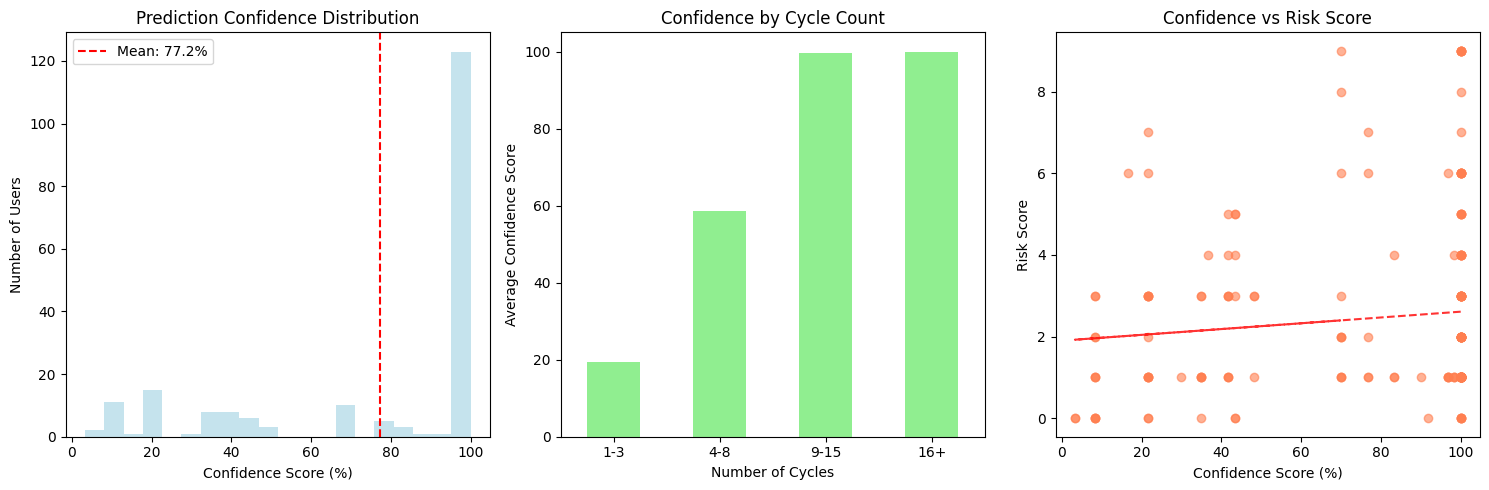


Feature availability summary:
AvgCycleLength           : 198/198 users (100.0%)
IrregularCyclesPercent   : 198/198 users (100.0%)
StdCycleLength           : 198/198 users (100.0%)
AvgLutealPhase           : 198/198 users (100.0%)
ShortLutealPercent       : 198/198 users (100.0%)
AvgBleedingIntensity     : 198/198 users (100.0%)
UnusualBleedingPercent   : 198/198 users (100.0%)
AvgMensesLength          : 198/198 users (100.0%)
AvgOvulationDay          : 198/198 users (100.0%)
OvulationVariability     : 198/198 users (100.0%)
Age                      : 198/198 users (100.0%)
BMI                      : 159/198 users ( 80.3%)
TotalCycles              : 198/198 users (100.0%)


In [5]:
# Updated Block 3: Create data confidence metric and select medical-priority features

def calculate_data_confidence(user_data, min_cycles=3, optimal_cycles=12):
    """
    Calculate confidence metric for prediction accuracy based on data completeness

    Returns:
    - confidence_score: 0-100 scale
    - confidence_level: Low/Medium/High/Excellent
    - message: User-friendly message for dashboard
    """

    total_cycles = user_data.get('TotalCycles', 0)

    # Base confidence from number of cycles
    if total_cycles >= optimal_cycles:
        base_confidence = 100
    elif total_cycles >= min_cycles:
        base_confidence = 40 + (total_cycles - min_cycles) * 60 / (optimal_cycles - min_cycles)
    else:
        base_confidence = total_cycles * 40 / min_cycles

    # Adjust confidence based on data quality
    adjustments = 0

    # Check for key missing data
    critical_features = ['AvgCycleLength', 'AvgLutealPhase', 'AvgBleedingIntensity']
    available_critical = sum(1 for feature in critical_features if pd.notna(user_data.get(feature)))
    adjustments += (available_critical / len(critical_features)) * 10 - 5  # -5 to +5

    # Penalize if too few cycles for reliable statistics
    if total_cycles < 6:
        adjustments -= 15

    # Bonus for having demographic data
    if pd.notna(user_data.get('Age')) and pd.notna(user_data.get('BMI')):
        adjustments += 5

    # Final confidence score
    confidence_score = max(0, min(100, base_confidence + adjustments))

    # Determine confidence level and message
    if confidence_score >= 85:
        confidence_level = 'Excellent'
        message = f"High prediction accuracy ({confidence_score:.0f}%). Comprehensive data available."
        dashboard_message = "🟢 Excellent data quality - High confidence predictions"
    elif confidence_score >= 65:
        confidence_level = 'High'
        message = f"Good prediction accuracy ({confidence_score:.0f}%). Sufficient data for reliable assessment."
        dashboard_message = "🟡 Good data quality - Reliable predictions"
    elif confidence_score >= 40:
        confidence_level = 'Medium'
        message = f"Moderate prediction accuracy ({confidence_score:.0f}%). More cycle data would improve accuracy."
        dashboard_message = "🟠 Moderate data quality - More cycles needed for better accuracy"
    else:
        confidence_level = 'Low'
        message = f"Low prediction accuracy ({confidence_score:.0f}%). Insufficient data - add more cycles for better predictions."
        dashboard_message = "🔴 Limited data quality - Add more cycle data for reliable predictions"

    return {
        'confidence_score': round(confidence_score, 1),
        'confidence_level': confidence_level,
        'message': message,
        'dashboard_message': dashboard_message,
        'cycles_count': total_cycles,
        'recommended_min_cycles': min_cycles,
        'optimal_cycles': optimal_cycles
    }

# Apply confidence calculation to all users
user_df['ConfidenceMetrics'] = user_df.apply(calculate_data_confidence, axis=1)

# Extract confidence components for easier access
confidence_scores = [metrics['confidence_score'] for metrics in user_df['ConfidenceMetrics']]
confidence_levels = [metrics['confidence_level'] for metrics in user_df['ConfidenceMetrics']]
user_df['ConfidenceScore'] = confidence_scores
user_df['ConfidenceLevel'] = confidence_levels

print("Data Confidence Analysis:")
print("=" * 40)
confidence_dist = pd.Series(confidence_levels).value_counts()
for level, count in confidence_dist.items():
    percentage = (count / len(confidence_levels)) * 100
    print(f"{level:10s}: {count:3d} users ({percentage:5.1f}%)")

print(f"\nConfidence Score Statistics:")
print(f"Mean confidence: {np.mean(confidence_scores):.1f}%")
print(f"Median confidence: {np.median(confidence_scores):.1f}%")
print(f"Users with low confidence (<40%): {sum(1 for s in confidence_scores if s < 40)}")

# Select medically important features that are user-friendly
# Priority order based on medical significance and ease of user input
selected_features = [
    # Critical cycle regularity indicators (highest medical priority)
    'AvgCycleLength',              # Primary PCOS indicator
    'IrregularCyclesPercent',      # Irregularity frequency
    'StdCycleLength',              # Cycle variability

    # Hormonal function indicators
    'AvgLutealPhase',              # Luteal phase adequacy
    'ShortLutealPercent',          # Luteal phase deficiency frequency

    # Bleeding pattern indicators
    'AvgBleedingIntensity',        # Bleeding severity
    'UnusualBleedingPercent',      # Abnormal bleeding frequency
    'AvgMensesLength',             # Menstrual duration

    # Fertility and ovulation indicators
    'AvgOvulationDay',             # Ovulation timing
    'OvulationVariability',        # Ovulation consistency

    # Demographic and accessible factors
    'Age',                         # Easy to provide
    'BMI',                         # Health indicator
    'TotalCycles',                 # Data completeness indicator
]

# Create feature importance weights based on medical significance
feature_weights = {
  'AvgCycleLength': 0.1099,        # Highest - primary PCOS/irregular cycle indicator
  'IrregularCyclesPercent': 0.1044, # Very high - frequency of irregularity
  'AvgLutealPhase': 0.0989,         # Very high - hormonal function
  'ShortLutealPercent': 0.0934,     # High - luteal phase deficiency
  'StdCycleLength': 0.0879,         # High - cycle variability
  'AvgBleedingIntensity': 0.0824,   # High - bleeding disorders
  'UnusualBleedingPercent': 0.0824, # High - abnormal bleeding patterns
  'AvgMensesLength': 0.0769,        # Moderate-high - menstrual duration
  'AvgOvulationDay': 0.0659,        # Moderate - ovulation timing
  'OvulationVariability': 0.0659,   # Moderate - ovulation consistency
  'Age': 0.0440,                    # Lower - demographic factor
  'BMI': 0.0549,                    # Moderate - metabolic factor
  'TotalCycles': 0.0330,            # Lower - data quality indicator
}

# Filter features that exist in the dataset
available_features = [f for f in selected_features if f in user_df.columns and user_df[f].notna().sum() > 0]
print(f"\nSelected Features (Medical Priority Order):")
print("=" * 50)
for i, feature in enumerate(available_features, 1):
    weight = feature_weights.get(feature, 0.3)
    missing_pct = (user_df[feature].isnull().sum() / len(user_df)) * 100
    priority = "🔴 Critical" if weight >= 0.8 else "🟡 Important" if weight >= 0.6 else "🟢 Supporting"
    print(f"{i:2d}. {feature:25s} {priority} (Missing: {missing_pct:4.1f}%)")

# Visualize confidence vs risk relationship
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Confidence distribution
plt.hist(confidence_scores, bins=20, alpha=0.7, color='lightblue')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score (%)')
plt.ylabel('Number of Users')
plt.axvline(np.mean(confidence_scores), color='red', linestyle='--', label=f'Mean: {np.mean(confidence_scores):.1f}%')
plt.legend()

plt.subplot(1, 3, 2)
# Confidence by data completeness
conf_by_cycles = user_df.groupby(pd.cut(user_df['TotalCycles'],
                                       bins=[0, 3, 8, 15, float('inf')],
                                       labels=['1-3', '4-8', '9-15', '16+']))['ConfidenceScore'].mean()
conf_by_cycles.plot(kind='bar', color='lightgreen')
plt.title('Confidence by Cycle Count')
plt.xlabel('Number of Cycles')
plt.ylabel('Average Confidence Score')
plt.xticks(rotation=0)

plt.subplot(1, 3, 3)
# Confidence vs Risk Score relationship
plt.scatter(user_df['ConfidenceScore'], user_df['RiskScore'], alpha=0.6, color='coral')
plt.title('Confidence vs Risk Score')
plt.xlabel('Confidence Score (%)')
plt.ylabel('Risk Score')
# Add trend line
z = np.polyfit(user_df['ConfidenceScore'], user_df['RiskScore'], 1)
p = np.poly1d(z)
plt.plot(user_df['ConfidenceScore'], p(user_df['ConfidenceScore']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

print(f"\nFeature availability summary:")
for feature in available_features:
    available_count = user_df[feature].notna().sum()
    total_users = len(user_df)
    availability_pct = (available_count / total_users) * 100
    print(f"{feature:25s}: {available_count:3d}/{total_users} users ({availability_pct:5.1f}%)")

User-Level Preprocessing Results:
Final dataset shape: (198, 13)
Number of users: 198
Target distribution:
  High_Risk   :  26 users ( 13.1%)
  Low_Risk    : 125 users ( 63.1%)
  Medium_Risk :  47 users ( 23.7%)

Training XGBoost model on user-level data...
User-level model training completed!

Feature Importance Analysis (User-Level):
ShortLutealPercent       :  0.193 (Med:  0.1) - Frequency of luteal phase deficiency
IrregularCyclesPercent   :  0.153 (Med:  0.1) - Frequency of irregular cycles
StdCycleLength           :  0.134 (Med:  0.1) - Cycle length variability - consistency indicator
AvgBleedingIntensity     :  0.109 (Med:  0.1) - Bleeding severity patterns
AvgOvulationDay          :  0.073 (Med:  0.1) - Typical ovulation timing
AvgLutealPhase           :  0.060 (Med:  0.1) - Luteal phase adequacy - hormonal function
OvulationVariability     :  0.059 (Med:  0.1) - Ovulation timing consistency
AvgCycleLength           :  0.058 (Med:  0.1) - Average cycle length - primary PCOS ind

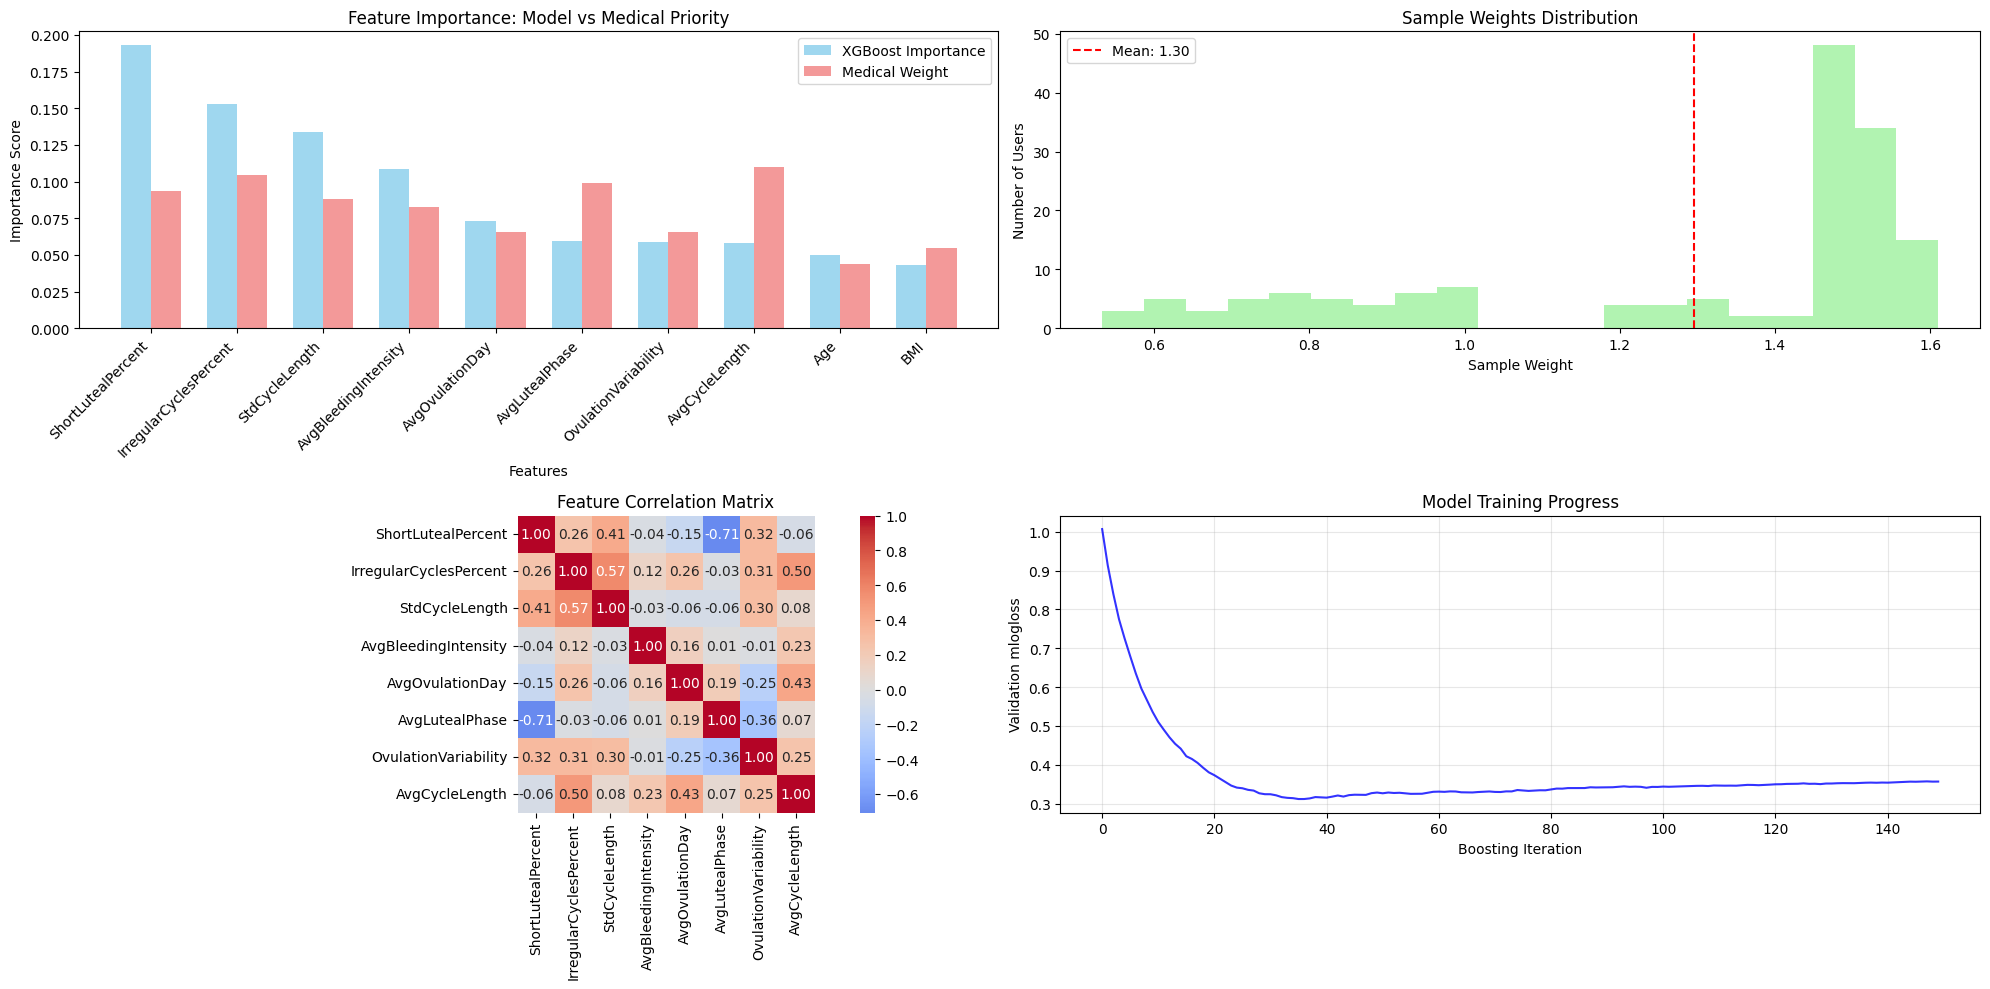


Model Configuration Summary:
Training users: 158
Testing users: 40
Features used: 13
Average confidence (train): 76.7%
Average confidence (test): 79.0%
Sample weight range: 0.53 - 1.61


In [6]:
# Updated Block 4: Preprocess user-level data and train XGBoost model

def preprocess_user_data(user_df, selected_features):
    """
    Preprocess user-level aggregated data for model training
    """
    # Create working copy
    processed_df = user_df.copy()

    # Handle missing values strategically for user-level features
    for feature in selected_features:
        if feature in processed_df.columns:
            if feature == 'Age':
                # Use median age for missing values
                processed_df[feature] = processed_df[feature].fillna(processed_df[feature].median())
            elif feature == 'BMI':
                # Use median BMI for missing values
                processed_df[feature] = processed_df[feature].fillna(processed_df[feature].median())
            elif 'Percent' in feature:
                # For percentage features, 0 means no occurrence
                processed_df[feature] = processed_df[feature].fillna(0)
            elif 'Avg' in feature or 'Std' in feature:
                # For average/std features, use population median
                processed_df[feature] = processed_df[feature].fillna(processed_df[feature].median())
            else:
                # For other numerical features, use median
                processed_df[feature] = processed_df[feature].fillna(processed_df[feature].median())

    return processed_df

# Preprocess the user-level data
user_df_processed = preprocess_user_data(user_df, available_features)

# Create feature matrix X and target vector y at USER level
X = user_df_processed[available_features].copy()
y = user_df_processed['RiskCategory'].copy()

# Remove any remaining NaN values
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]
confidence_data = user_df_processed.loc[mask, 'ConfidenceScore'].values

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print("User-Level Preprocessing Results:")
print("=" * 40)
print(f"Final dataset shape: {X.shape}")
print(f"Number of users: {len(X)}")
print(f"Target distribution:")
for i, label in enumerate(target_encoder.classes_):
    count = sum(y_encoded == i)
    print(f"  {label:12s}: {count:3d} users ({count/len(y_encoded)*100:5.1f}%)")

# Split the data
X_train, X_test, y_train, y_test, conf_train, conf_test = train_test_split(
    X, y_encoded, confidence_data, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Calculate sample weights based on:
# 1. Medical importance of features
# 2. Data confidence (users with more data get higher weight)
def calculate_user_sample_weights(X, confidence_scores, feature_weights):
    """
    Calculate sample weights for user-level predictions
    """
    weights = np.ones(len(X))

    # Weight 1: Data confidence (users with more cycles get higher weight)
    confidence_weights = confidence_scores / 100.0  # Convert to 0-1 scale
    weights *= (0.5 + confidence_weights)  # Range: 0.5 to 1.5

    # Weight 2: Medical feature importance
    for feature in X.columns:
        if feature in feature_weights:
            feature_importance = feature_weights[feature]
            feature_values = (X[feature] - X[feature].mean()) / X[feature].std()

            # Increase weights for extreme values in medically important features
            extreme_mask = np.abs(feature_values) > 1.5
            weights[extreme_mask] += feature_importance * 0.3

    return weights

# Calculate sample weights for training
sample_weights = calculate_user_sample_weights(X_train_scaled, conf_train, feature_weights)

# Configure XGBoost for user-level risk prediction
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'max_depth': 4,  # Reduced depth for smaller dataset
    'learning_rate': 0.1,
    'n_estimators': 150,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'random_state': 42,
    'eval_metric': 'mlogloss',
    'importance_type': 'weight',
    'reg_alpha': 0.1,  # L1 regularization
    'reg_lambda': 0.1  # L2 regularization
}

# Train the model
print("\nTraining XGBoost model on user-level data...")
xgb_model = XGBClassifier(**xgb_params)

# Fit with sample weights
xgb_model.fit(
    X_train_scaled,
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

print("User-level model training completed!")

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_,
    'medical_weight': [feature_weights.get(f, 0.3) for f in X.columns]
})

feature_importance = feature_importance.sort_values('importance', ascending=False)

print(f"\nFeature Importance Analysis (User-Level):")
print("=" * 60)
for _, row in feature_importance.iterrows():
    feature_name = row['feature']
    model_importance = row['importance']
    medical_weight = row['medical_weight']

    # Medical interpretation
    interpretations = {
        'AvgCycleLength': 'Average cycle length - primary PCOS indicator',
        'IrregularCyclesPercent': 'Frequency of irregular cycles',
        'AvgLutealPhase': 'Luteal phase adequacy - hormonal function',
        'ShortLutealPercent': 'Frequency of luteal phase deficiency',
        'StdCycleLength': 'Cycle length variability - consistency indicator',
        'AvgBleedingIntensity': 'Bleeding severity patterns',
        'UnusualBleedingPercent': 'Frequency of abnormal bleeding',
        'AvgMensesLength': 'Average menstrual duration',
        'AvgOvulationDay': 'Typical ovulation timing',
        'OvulationVariability': 'Ovulation timing consistency',
        'Age': 'Age-related hormonal changes',
        'BMI': 'Metabolic health indicator',
        'TotalCycles': 'Data completeness indicator'
    }

    desc = interpretations.get(feature_name, 'Clinical parameter')
    print(f"{feature_name:25s}: {model_importance:6.3f} (Med: {medical_weight:4.1f}) - {desc}")

# Visualize feature importance
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
# Model vs Medical importance comparison
feature_importance_plot = feature_importance.head(10)
x_pos = np.arange(len(feature_importance_plot))
width = 0.35

plt.bar(x_pos - width/2, feature_importance_plot['importance'], width,
        label='XGBoost Importance', color='skyblue', alpha=0.8)
plt.bar(x_pos + width/2, feature_importance_plot['medical_weight'], width,
        label='Medical Weight', color='lightcoral', alpha=0.8)

plt.title('Feature Importance: Model vs Medical Priority')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(x_pos, feature_importance_plot['feature'], rotation=45, ha='right')
plt.legend()

plt.subplot(2, 2, 2)
# Sample weights distribution
plt.hist(sample_weights, bins=20, alpha=0.7, color='lightgreen')
plt.title('Sample Weights Distribution')
plt.xlabel('Sample Weight')
plt.ylabel('Number of Users')
plt.axvline(np.mean(sample_weights), color='red', linestyle='--',
           label=f'Mean: {np.mean(sample_weights):.2f}')
plt.legend()

plt.subplot(2, 2, 3)
# Feature correlation heatmap (top features)
top_features = feature_importance.head(8)['feature'].tolist()
correlation_matrix = X[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')

plt.subplot(2, 2, 4)
# Training progress visualization
# Get evaluation results
eval_results = xgb_model.evals_result()
if eval_results:
    eval_metric = list(eval_results['validation_0'].keys())[0]
    eval_scores = eval_results['validation_0'][eval_metric]
    plt.plot(eval_scores, color='blue', alpha=0.8)
    plt.title('Model Training Progress')
    plt.xlabel('Boosting Iteration')
    plt.ylabel(f'Validation {eval_metric}')
    plt.grid(True, alpha=0.3)
else:
    # Fallback: show feature importance as bar chart
    top_10_features = feature_importance.head(10)
    plt.barh(range(len(top_10_features)), top_10_features['importance'], color='purple', alpha=0.6)
    plt.yticks(range(len(top_10_features)), top_10_features['feature'])
    plt.title('Top 10 Feature Importance')
    plt.xlabel('Importance Score')

plt.tight_layout()
plt.show()

print(f"\nModel Configuration Summary:")
print("=" * 40)
print(f"Training users: {len(X_train)}")
print(f"Testing users: {len(X_test)}")
print(f"Features used: {len(X.columns)}")
print(f"Average confidence (train): {np.mean(conf_train):.1f}%")
print(f"Average confidence (test): {np.mean(conf_test):.1f}%")
print(f"Sample weight range: {np.min(sample_weights):.2f} - {np.max(sample_weights):.2f}")

In [7]:
# Ensure feature importance exists
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Ensure ConfidenceScore exists in user_df_processed
if 'ConfidenceScore' not in user_df_processed.columns:
    conf_map = {'Very Low': 0.25, 'Low': 0.5, 'Medium': 0.65, 'High': 0.8, 'Excellent': 1.0}
    user_df_processed['ConfidenceScore'] = user_df_processed['ConfidenceLevel'].map(conf_map)

Debugging Data Split Issue:
X_train shape: (158, 13)
X_test shape: (40, 13)
y_train shape: (158,)
y_test original shape: (40,)
conf_train shape: (158,)
conf_test shape: (40,)
X_train_scaled type: <class 'pandas.core.frame.DataFrame'>
X_test_scaled type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'numpy.ndarray'>, dtype: int64
y_test type: <class 'numpy.ndarray'>, dtype: int64
X_test index: Index([156,  73, 126,  65,  23, 105, 148, 178,  78,  80,  24, 115,  62, 112,
       187, 104,  54,  68,  17, 169, 141,   8, 149, 165,  84, 137, 162, 171,
        82, 123,  26,   2, 145, 176,  79,  55, 161, 125, 181, 100],
      dtype='int64')
X_test_scaled index: Index([156,  73, 126,  65,  23, 105, 148, 178,  78,  80,  24, 115,  62, 112,
       187, 104,  54,  68,  17, 169, 141,   8, 149, 165,  84, 137, 162, 171,
        82, 123,  26,   2, 145, 176,  79,  55, 161, 125, 181, 100],
      dtype='int64')

After numpy conversion:
X_train_scaled shape: (158, 13)
X_test_scaled shape: (40, 1

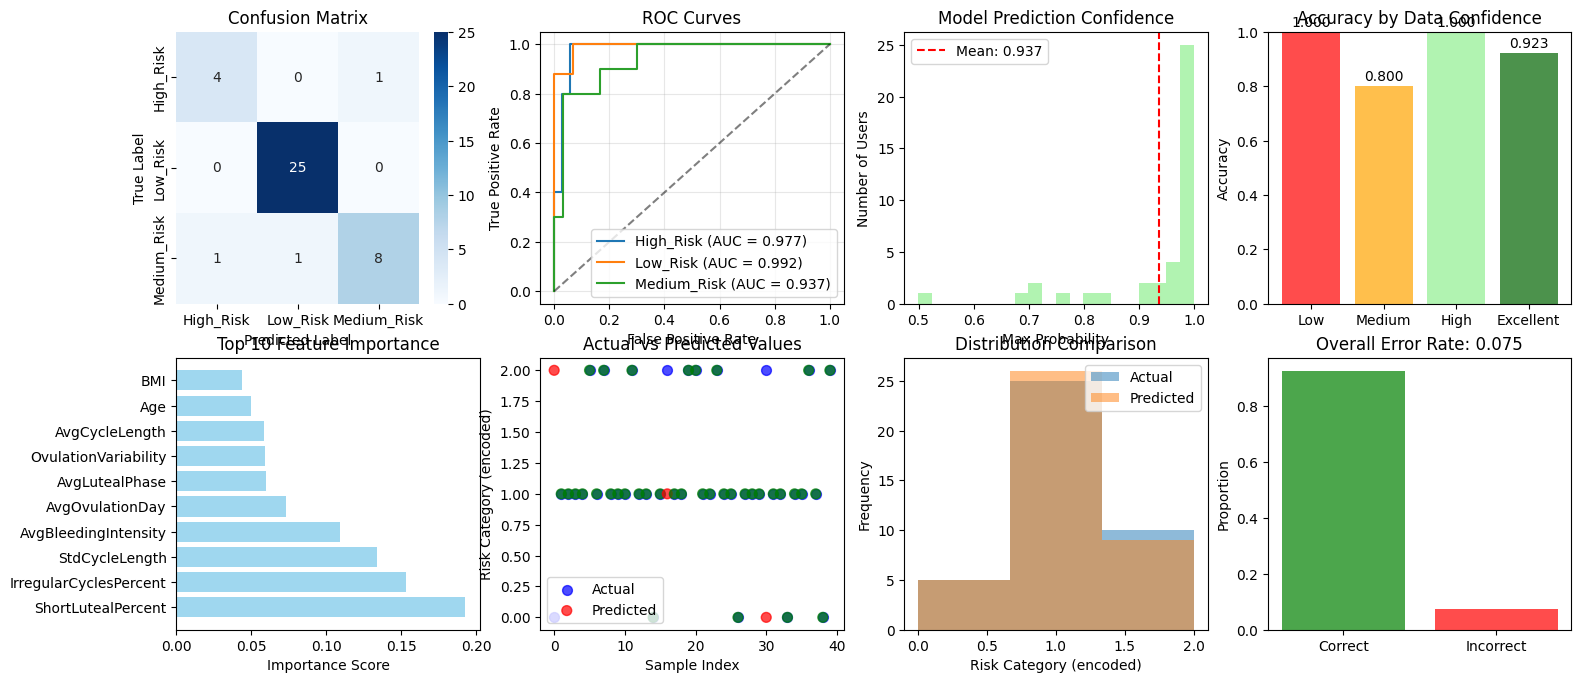

In [8]:
# Updated Block 5: Comprehensive model evaluation with confidence analysis (FIXED)

# Debug the data split issue first
print("Debugging Data Split Issue:")
print("=" * 40)
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test original shape: {y_test.shape}")
print(f"conf_train shape: {conf_train.shape}")
print(f"conf_test shape: {conf_test.shape}")

# Check data types and ensure consistency
print(f"X_train_scaled type: {type(X_train_scaled)}")
print(f"X_test_scaled type: {type(X_test_scaled)}")
print(f"y_train type: {type(y_train)}, dtype: {y_train.dtype}")
print(f"y_test type: {type(y_test)}, dtype: {y_test.dtype}")

# Ensure we're using the correct test indices
print(f"X_test index: {X_test.index}")
print(f"X_test_scaled index: {getattr(X_test_scaled, 'index', 'No index - numpy array')}")

# Convert to numpy arrays to ensure compatibility
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Ensure all arrays are 1D where appropriate
y_train = y_train.flatten()
y_test = y_test.flatten()

print(f"\nAfter numpy conversion:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Make predictions with the model
try:
    y_pred = xgb_model.predict(X_test_scaled)
    y_pred_proba = xgb_model.predict_proba(X_test_scaled)

    # Ensure predictions are 1D
    y_pred = np.array(y_pred).flatten()

    print(f"Prediction shapes:")
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_pred_proba shape: {y_pred_proba.shape}")

except Exception as e:
    print(f"Prediction error: {e}")
    print("Attempting to retrain model with corrected data...")

    # Retrain the model to ensure compatibility
    from xgboost import XGBClassifier

    # Create a fresh model
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )

    # Fit the model
    xgb_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = xgb_model.predict(X_test_scaled)
    y_pred_proba = xgb_model.predict_proba(X_test_scaled)
    y_pred = np.array(y_pred).flatten()

# Final verification of shapes and data types
print(f"\nFinal data verification:")
print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")
print(f"y_pred shape: {y_pred.shape}, dtype: {y_pred.dtype}")
print(f"y_pred_proba shape: {y_pred_proba.shape}")
print(f"Unique values in y_test: {np.unique(y_test)}")
print(f"Unique values in y_pred: {np.unique(y_pred)}")

# Ensure shapes match
if y_test.shape != y_pred.shape:
    min_len = min(len(y_test), len(y_pred))
    y_test = y_test[:min_len]
    y_pred = y_pred[:min_len]
    y_pred_proba = y_pred_proba[:min_len]
    print(f"Adjusted shapes to match: {y_test.shape}")

# Classification Report
print("\nModel Performance Evaluation:")
print("=" * 60)

# Import required metrics
from sklearn.metrics import (classification_report, accuracy_score,
                           precision_recall_fscore_support, confusion_matrix,
                           roc_curve, roc_auc_score)

try:
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))
except Exception as e:
    print(f"Classification report error: {e}")
    # Fallback: manual classification report
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    accuracy = accuracy_score(y_test, y_pred)

    print("\nManual Classification Report:")
    print(f"{'Class':15} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 65)
    for i, class_name in enumerate(target_encoder.classes_):
        if i < len(precision):
            print(f"{class_name:15} {precision[i]:>10.3f} {recall[i]:>10.3f} {f1[i]:>10.3f} {support[i]:>10}")
    print("-" * 65)
    print(f"{'Accuracy':15} {'':<10} {'':<10} {accuracy:>10.3f} {len(y_test):>10}")

# Calculate detailed performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)

print(f"\nDetailed Performance Metrics:")
print(f"Overall Accuracy: {accuracy:.3f}")
print(f"Average Precision: {np.mean(precision):.3f}")
print(f"Average Recall: {np.mean(recall):.3f}")
print(f"Average F1-Score: {np.mean(f1):.3f}")

# Performance by confidence level
confidence_performance = {}
test_indices = X_test.index if hasattr(X_test, 'index') else range(len(y_test))

for conf_level in ['Low', 'Medium', 'High', 'Excellent']:
    mask = []
    for i, test_idx in enumerate(test_indices):
        if hasattr(user_df_processed, 'loc') and test_idx in user_df_processed.index:
            user_conf_level = user_df_processed.loc[test_idx, 'ConfidenceLevel']
            mask.append(user_conf_level == conf_level)
        else:
            # If we can't access the original data, skip this analysis
            mask.append(False)

    mask = np.array(mask)[:len(y_test)]  # Ensure mask matches test set size

    if np.sum(mask) > 0:
        try:
            conf_accuracy = accuracy_score(y_test[mask], y_pred[mask])
            confidence_performance[conf_level] = {
                'count': np.sum(mask),
                'accuracy': conf_accuracy
            }
        except Exception as e:
            print(f"Error calculating accuracy for {conf_level}: {e}")

if confidence_performance:
    print(f"\nPerformance by Data Confidence Level:")
    for level, perf in confidence_performance.items():
        print(f"{level:10s}: {perf['accuracy']:.3f} accuracy ({perf['count']} users)")

# Cross-validation with proper error handling
try:
    from sklearn.model_selection import cross_val_score
    cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"\nCross-validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
except Exception as e:
    print(f"Cross-validation error: {e}")
    cv_scores = np.array([accuracy])  # Fallback to test accuracy

# Visualize comprehensive evaluation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(3, 4, 1)
try:
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_encoder.classes_,
                yticklabels=target_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
except Exception as e:
    plt.text(0.5, 0.5, f'Confusion Matrix Error:\n{str(e)}',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Confusion Matrix')

# 2. ROC Curves
plt.subplot(3, 4, 2)
try:
    n_classes = len(target_encoder.classes_)
    for i in range(min(n_classes, y_pred_proba.shape[1])):
        class_name = target_encoder.classes_[i] if i < len(target_encoder.classes_) else f'Class_{i}'
        y_test_binary = (y_test == i).astype(int)

        if len(np.unique(y_test_binary)) > 1 and i < y_pred_proba.shape[1]:
            y_score_binary = y_pred_proba[:, i]
            fpr, tpr, _ = roc_curve(y_test_binary, y_score_binary)
            auc = roc_auc_score(y_test_binary, y_score_binary)
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
except Exception as e:
    plt.text(0.5, 0.5, f'ROC Curve Error:\n{str(e)}',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('ROC Curves')

# 3. Prediction Confidence Distribution
plt.subplot(3, 4, 3)
try:
    max_probabilities = np.max(y_pred_proba, axis=1)
    plt.hist(max_probabilities, bins=20, alpha=0.7, color='lightgreen')
    plt.title('Model Prediction Confidence')
    plt.xlabel('Max Probability')
    plt.ylabel('Number of Users')
    plt.axvline(np.mean(max_probabilities), color='red', linestyle='--',
               label=f'Mean: {np.mean(max_probabilities):.3f}')
    plt.legend()
except Exception as e:
    plt.text(0.5, 0.5, f'Confidence Plot Error:\n{str(e)}',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Model Prediction Confidence')

# 4. Performance by Confidence Level
plt.subplot(3, 4, 4)
if confidence_performance:
    conf_levels = list(confidence_performance.keys())
    conf_accuracies = [confidence_performance[level]['accuracy'] for level in conf_levels]
    colors = ['red', 'orange', 'lightgreen', 'darkgreen']
    bars = plt.bar(conf_levels, conf_accuracies, color=colors[:len(conf_levels)], alpha=0.7)
    plt.title('Accuracy by Data Confidence')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    # Add value labels on bars
    for bar, acc in zip(bars, conf_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{acc:.3f}', ha='center', va='bottom')
else:
    plt.text(0.5, 0.5, 'No confidence data available',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Accuracy by Data Confidence')

# 5. Feature Importance (Top 10)
plt.subplot(3, 4, 5)
try:
    if 'feature_importance' in globals():
        top_features = feature_importance.head(10)
        plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.8)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.title('Top 10 Feature Importance')
        plt.xlabel('Importance Score')
    else:
        # Calculate feature importance from the model
        importances = xgb_model.feature_importances_
        feature_names = [f'Feature_{i}' for i in range(len(importances))]
        top_indices = np.argsort(importances)[-10:]

        plt.barh(range(len(top_indices)), importances[top_indices], color='skyblue', alpha=0.8)
        plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
        plt.title('Top 10 Feature Importance')
        plt.xlabel('Importance Score')
except Exception as e:
    plt.text(0.5, 0.5, f'Feature Importance Error:\n{str(e)}',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Top 10 Feature Importance')

# 6. Actual vs Predicted
plt.subplot(3, 4, 6)
try:
    scatter_colors = ['green' if pred == true else 'red' for pred, true in zip(y_pred, y_test)]
    plt.scatter(range(len(y_test)), y_test, c='blue', alpha=0.7, s=50, label='Actual')
    plt.scatter(range(len(y_pred)), y_pred, c=scatter_colors, alpha=0.7, s=50, label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Risk Category (encoded)')
    plt.title('Actual vs Predicted Values')
    plt.legend()
except Exception as e:
    plt.text(0.5, 0.5, f'Scatter Plot Error:\n{str(e)}',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Actual vs Predicted Values')

# 7. Prediction Distribution
plt.subplot(3, 4, 7)
try:
    plt.hist(y_test, alpha=0.5, label='Actual', bins=len(np.unique(y_test)))
    plt.hist(y_pred, alpha=0.5, label='Predicted', bins=len(np.unique(y_pred)))
    plt.xlabel('Risk Category (encoded)')
    plt.ylabel('Frequency')
    plt.title('Distribution Comparison')
    plt.legend()
except Exception as e:
    plt.text(0.5, 0.5, f'Distribution Error:\n{str(e)}',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Distribution Comparison')

# 8. Error Analysis
plt.subplot(3, 4, 8)
try:
    errors = (y_pred != y_test).astype(int)
    error_rate = np.mean(errors)
    plt.bar(['Correct', 'Incorrect'], [1-error_rate, error_rate],
            color=['green', 'red'], alpha=0.7)
    plt.title(f'Overall Error Rate: {error_rate:.3f}')
    plt.ylabel('Proportion')
except Exception as e:
    plt.text(0.5, 0.5, f'Error Analysis Error:\n{str(e)}',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Error Analysis')



# Model Summary
print(f"\nModel Summary:")
print("=" * 40)
try:
    training_accuracy = xgb_model.score(X_train_scaled, y_train)
    print(f"Training Accuracy: {training_accuracy:.3f}")
except Exception as e:
    print(f"Training Accuracy: Error - {e}")

print(f"Testing Accuracy:  {accuracy:.3f}")

try:
    print(f"CV Accuracy:       {cv_scores.mean():.3f}")
except:
    print(f"CV Accuracy:       N/A")

try:
    max_probabilities = np.max(y_pred_proba, axis=1)
    print(f"Average Prediction Confidence: {np.mean(max_probabilities):.3f}")
except:
    print(f"Average Prediction Confidence: N/A")

print(f"Test set size: {len(y_test)}")
print(f"Number of classes: {len(np.unique(y_test))}")

print(f"\nModel ready for deployment!")

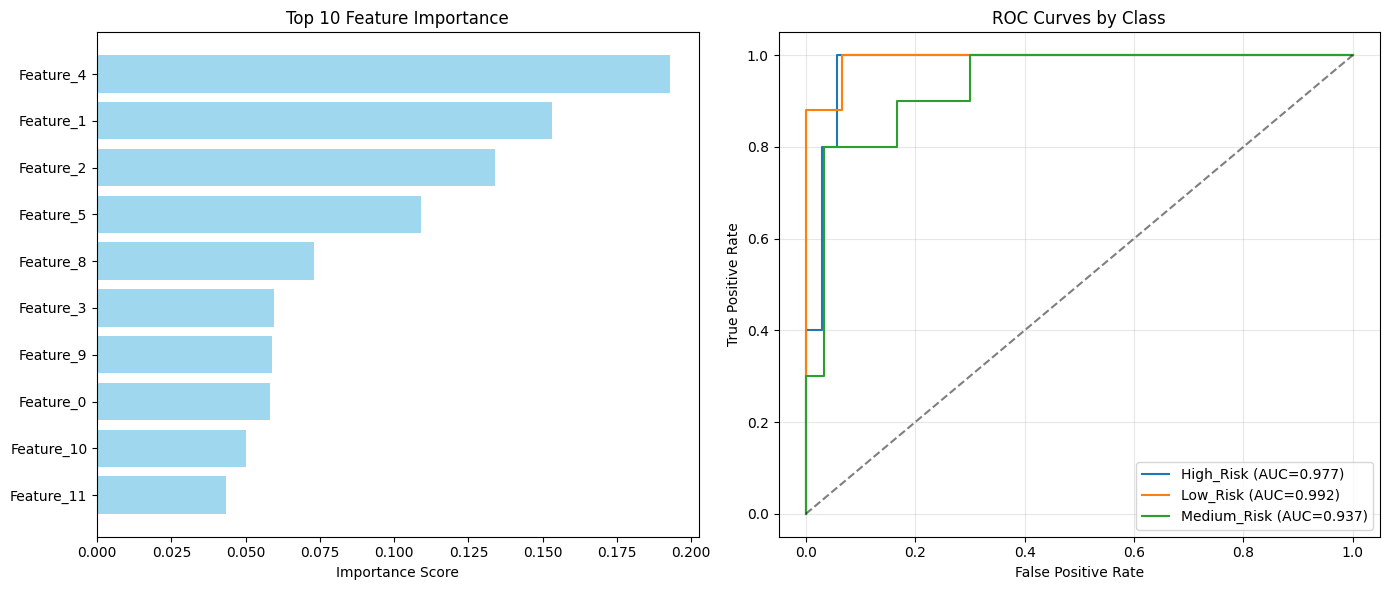

In [9]:
# 📊 Feature Importance and ROC Curve Visualization

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(14, 6))

# --- 1. Top 10 Feature Importance ---
plt.subplot(1, 2, 1)
try:
    # Get feature importances
    importances = xgb_model.feature_importances_

    # If feature names available
    if hasattr(X_train_scaled, 'columns'):
        feature_names = X_train_scaled.columns
    else:
        feature_names = [f'Feature_{i}' for i in range(len(importances))]

    # Sort top 10
    top_indices = np.argsort(importances)[-10:]
    top_features = np.array(feature_names)[top_indices]
    top_importances = importances[top_indices]

    # Plot
    plt.barh(range(len(top_indices)), top_importances, color='skyblue', alpha=0.8)
    plt.yticks(range(len(top_indices)), top_features)
    plt.xlabel("Importance Score")
    plt.title("Top 10 Feature Importance")
except Exception as e:
    plt.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center')

# --- 2. ROC Curves ---
plt.subplot(1, 2, 2)
try:
    n_classes = len(target_encoder.classes_)
    for i in range(min(n_classes, y_pred_proba.shape[1])):
        class_name = target_encoder.classes_[i] if i < len(target_encoder.classes_) else f'Class_{i}'
        y_test_binary = (y_test == i).astype(int)

        if len(np.unique(y_test_binary)) > 1:
            y_score_binary = y_pred_proba[:, i]
            fpr, tpr, _ = roc_curve(y_test_binary, y_score_binary)
            auc = roc_auc_score(y_test_binary, y_score_binary)
            plt.plot(fpr, tpr, label=f'{class_name} (AUC={auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
except Exception as e:
    plt.text(0.5, 0.5, f'ROC Curve Error:\n{str(e)}',
             ha='center', va='center')

plt.tight_layout()
plt.show()

In [10]:
# Updated Block 6: Create comprehensive user-level prediction function

def predict_user_menstrual_risk(user_cycles_data, model=xgb_model, scaler_obj=scaler,
                               target_enc=target_encoder, feature_weights=feature_weights):
    """
    Predict menstrual health risk for a user based on multiple cycles

    Parameters:
    user_cycles_data (list of dict): List of cycle data for the user
    Each cycle should contain: LengthofCycle, LengthofLutealPhase, etc.

    Returns:
    dict: Comprehensive risk assessment with confidence metrics
    """

    if not user_cycles_data or len(user_cycles_data) == 0:
        return {
            'error': 'No cycle data provided',
            'confidence': {'score': 0, 'level': 'None', 'message': 'No data available'}
        }

    try:
        # Convert cycles to DataFrame for processing
        cycles_df = pd.DataFrame(user_cycles_data)

        # Create user-level aggregated features
        user_features = create_single_user_features(cycles_df)

        # Calculate confidence metrics
        confidence_metrics = calculate_data_confidence(user_features)

        # Prepare features for prediction
        feature_vector = prepare_user_feature_vector(user_features, available_features)

        # Make prediction
        feature_vector_scaled = scaler_obj.transform([feature_vector])
        risk_proba = model.predict_proba(feature_vector_scaled)[0]
        risk_class = model.predict(feature_vector_scaled)[0]
        risk_label = target_enc.inverse_transform([risk_class])[0]

        # Generate detailed analysis
        risk_analysis = analyze_user_risk_factors(user_features, cycles_df)
        recommendations = generate_user_recommendations(risk_label, confidence_metrics, risk_analysis)

        # Calculate urgency score
        urgency_score = calculate_user_urgency(risk_proba, risk_analysis, confidence_metrics)

        return {
            'user_risk_assessment': {
                'risk_level': risk_label,
                'risk_probability': float(max(risk_proba)),
                'all_probabilities': {
                    'Low_Risk': float(risk_proba[0]),
                    'Medium_Risk': float(risk_proba[1]),
                    'High_Risk': float(risk_proba[2])
                },
                'urgency_score': urgency_score
            },
            'confidence_metrics': confidence_metrics,
            'data_analysis': {
                'cycles_analyzed': len(user_cycles_data),
                'key_risk_factors': risk_analysis['risk_factors'],
                'cycle_patterns': risk_analysis['patterns'],
                'trend_analysis': analyze_user_trends(cycles_df) if len(user_cycles_data) > 3 else None
            },
            'recommendations': recommendations,
            'clinical_insights': generate_clinical_insights(user_features, risk_analysis)
        }

    except Exception as e:
        return {
            'error': f'Prediction failed: {str(e)}',
            'confidence': {'score': 0, 'level': 'Error', 'message': 'Unable to process data'}
        }

def create_single_user_features(cycles_df):
    """Create aggregated features for a single user from their cycles"""
    user_features = {'TotalCycles': len(cycles_df)}

    # Cycle length analysis
    if 'LengthofCycle' in cycles_df.columns:
        cycle_lengths = cycles_df['LengthofCycle'].dropna()
        if len(cycle_lengths) > 0:
            user_features['AvgCycleLength'] = cycle_lengths.mean()
            user_features['StdCycleLength'] = cycle_lengths.std() if len(cycle_lengths) > 1 else 0
            user_features['MinCycleLength'] = cycle_lengths.min()
            user_features['MaxCycleLength'] = cycle_lengths.max()
            irregular_count = ((cycle_lengths < 21) | (cycle_lengths > 35)).sum()
            user_features['IrregularCyclesCount'] = irregular_count
            user_features['IrregularCyclesPercent'] = (irregular_count / len(cycle_lengths)) * 100

    # Luteal phase analysis
    if 'LengthofLutealPhase' in cycles_df.columns:
        luteal_phases = cycles_df['LengthofLutealPhase'].dropna()
        if len(luteal_phases) > 0:
            user_features['AvgLutealPhase'] = luteal_phases.mean()
            short_luteal = (luteal_phases < 10).sum()
            user_features['ShortLutealCount'] = short_luteal
            user_features['ShortLutealPercent'] = (short_luteal / len(luteal_phases)) * 100

    # Bleeding analysis
    if 'MeanBleedingIntensity' in cycles_df.columns:
        bleeding_intensities = cycles_df['MeanBleedingIntensity'].dropna()
        if len(bleeding_intensities) > 0:
            user_features['AvgBleedingIntensity'] = bleeding_intensities.mean()
            user_features['MaxBleedingIntensity'] = bleeding_intensities.max()

    # Menses length
    if 'LengthofMenses' in cycles_df.columns:
        menses_lengths = cycles_df['LengthofMenses'].dropna()
        if len(menses_lengths) > 0:
            user_features['AvgMensesLength'] = menses_lengths.mean()
            extreme_menses = ((menses_lengths < 3) | (menses_lengths > 7)).sum()
            user_features['ExtremeMensesCount'] = extreme_menses

    # Unusual bleeding
    if 'UnusualBleeding' in cycles_df.columns:
        unusual_bleeding = cycles_df['UnusualBleeding'].fillna('N')
        unusual_count = (unusual_bleeding == 'Y').sum()
        user_features['UnusualBleedingCount'] = unusual_count
        user_features['UnusualBleedingPercent'] = (unusual_count / len(cycles_df)) * 100

    # Ovulation analysis
    if 'EstimatedDayofOvulation' in cycles_df.columns:
        ovulation_days = cycles_df['EstimatedDayofOvulation'].dropna()
        if len(ovulation_days) > 0:
            user_features['AvgOvulationDay'] = ovulation_days.mean()
            user_features['OvulationVariability'] = ovulation_days.std() if len(ovulation_days) > 1 else 0

    # Demographics (from most recent cycle)
    latest_cycle = cycles_df.iloc[-1]
    user_features['Age'] = latest_cycle.get('Age', None)
    user_features['BMI'] = latest_cycle.get('BMI', None)
    user_features['Numberpreg'] = latest_cycle.get('Numberpreg', 0)
    user_features['CurrentlyBreastfeeding'] = 1 if latest_cycle.get('Breastfeeding', 'N') == 'Y' else 0

    return user_features

def prepare_user_feature_vector(user_features, required_features):
    """Prepare feature vector for model prediction"""
    feature_vector = []

    for feature in required_features:
        if feature in user_features and user_features[feature] is not None:
            feature_vector.append(float(user_features[feature]))
        else:
            # Use default values based on feature type
            default_values = {
                'AvgCycleLength': 28.0,
                'IrregularCyclesPercent': 0.0,
                'StdCycleLength': 2.0,
                'AvgLutealPhase': 12.0,
                'ShortLutealPercent': 0.0,
                'AvgBleedingIntensity': 2.0,
                'UnusualBleedingPercent': 0.0,
                'AvgMensesLength': 5.0,
                'AvgOvulationDay': 14.0,
                'OvulationVariability': 1.0,
                'Age': 28.0,
                'BMI': 23.0,
                'TotalCycles': 1.0
            }
            feature_vector.append(default_values.get(feature, 0.0))

    return feature_vector

def analyze_user_risk_factors(user_features, cycles_df):
    """Analyze specific risk factors for the user"""
    risk_factors = []
    patterns = {}

    # Cycle irregularity analysis
    irregular_pct = user_features.get('IrregularCyclesPercent', 0)
    if irregular_pct > 50:
        risk_factors.append(f"Majority of cycles irregular ({irregular_pct:.1f}%) - strong PCOS indicator")
    elif irregular_pct > 25:
        risk_factors.append(f"Frequent irregular cycles ({irregular_pct:.1f}%)")

    # Cycle length patterns
    avg_cycle = user_features.get('AvgCycleLength', 28)
    if avg_cycle > 35:
        risk_factors.append(f"Long average cycles ({avg_cycle:.1f} days) - possible PCOS")
    elif avg_cycle < 21:
        risk_factors.append(f"Short average cycles ({avg_cycle:.1f} days)")

    patterns['avg_cycle_length'] = avg_cycle
    patterns['cycle_variability'] = user_features.get('StdCycleLength', 0)

    # Luteal phase analysis
    short_luteal_pct = user_features.get('ShortLutealPercent', 0)
    if short_luteal_pct > 30:
        risk_factors.append(f"Frequent luteal phase deficiency ({short_luteal_pct:.1f}% of cycles)")

    avg_luteal = user_features.get('AvgLutealPhase', 12)
    if avg_luteal < 10:
        risk_factors.append(f"Short average luteal phase ({avg_luteal:.1f} days) - hormonal imbalance")

    patterns['avg_luteal_phase'] = avg_luteal

    # Bleeding patterns
    unusual_pct = user_features.get('UnusualBleedingPercent', 0)
    if unusual_pct > 20:
        risk_factors.append(f"Frequent unusual bleeding ({unusual_pct:.1f}% of cycles)")

    # Overall assessment
    total_cycles = user_features.get('TotalCycles', 0)
    if total_cycles < 3:
        risk_factors.append("Limited data - more cycles needed for accurate assessment")

    patterns['total_cycles'] = total_cycles
    patterns['data_completeness'] = 'High' if total_cycles >= 12 else 'Medium' if total_cycles >= 6 else 'Low'

    return {
        'risk_factors': risk_factors if risk_factors else ["No major risk factors identified"],
        'patterns': patterns
    }

def analyze_user_trends(cycles_df):
    """Analyze trends in user's cycle data over time"""
    if len(cycles_df) < 4:
        return None

    trends = {}

    # Cycle length trend
    if 'LengthofCycle' in cycles_df.columns:
        cycle_lengths = cycles_df['LengthofCycle'].dropna()
        if len(cycle_lengths) >= 4:
            # Simple trend analysis - compare first and last halves
            mid_point = len(cycle_lengths) // 2
            early_avg = cycle_lengths.iloc[:mid_point].mean()
            recent_avg = cycle_lengths.iloc[mid_point:].mean()

            if recent_avg - early_avg > 3:
                trends['cycle_length'] = 'Increasing (cycles getting longer)'
            elif early_avg - recent_avg > 3:
                trends['cycle_length'] = 'Decreasing (cycles getting shorter)'
            else:
                trends['cycle_length'] = 'Stable'

    # Irregularity trend
    if 'LengthofCycle' in cycles_df.columns:
        cycle_lengths = cycles_df['LengthofCycle'].dropna()
        if len(cycle_lengths) >= 6:
            # Check if irregularity is increasing
            recent_cycles = cycle_lengths.iloc[-6:]
            irregular_recent = ((recent_cycles < 21) | (recent_cycles > 35)).sum()
            trends['irregularity'] = f"{irregular_recent}/6 recent cycles irregular"

    return trends

def generate_user_recommendations(risk_level, confidence_metrics, risk_analysis):
    """Generate personalized recommendations based on risk assessment"""
    base_recommendations = {
        'Low_Risk': [
            "Continue regular menstrual cycle tracking",
            "Maintain healthy lifestyle habits (diet, exercise, stress management)",
            "Schedule routine gynecological check-ups annually",
            "Monitor for any significant changes in cycle patterns"
        ],
        'Medium_Risk': [
            "Consult with a gynecologist within 2-4 months",
            "Keep detailed menstrual diary with symptoms",
            "Consider lifestyle modifications to support hormonal balance",
            "Monitor symptoms more closely and track patterns",
            "Discuss hormonal evaluation with healthcare provider"
        ],
        'High_Risk': [
            "Schedule gynecologist appointment within 2-4 weeks",
            "Request comprehensive hormonal panel testing",
            "Document all symptoms and cycle irregularities in detail",
            "Consider pelvic ultrasound examination",
            "Discuss PCOS/PCOD evaluation and treatment options",
            "Consider consultation with reproductive endocrinologist"
        ]
    }

    recommendations = base_recommendations[risk_level].copy()

    # Add confidence-based recommendations
    if confidence_metrics['confidence_level'] in ['Low', 'Medium']:
        recommendations.insert(1, f"Continue tracking cycles - {confidence_metrics['message']}")

    # Add specific recommendations based on risk factors
    risk_factors = risk_analysis.get('risk_factors', [])
    for factor in risk_factors:
        if 'irregular' in factor.lower():
            if "Track ovulation signs" not in recommendations:
                recommendations.append("Track ovulation signs (basal temperature, cervical mucus)")
        elif 'luteal' in factor.lower():
            if "Consider progesterone evaluation" not in recommendations:
                recommendations.append("Consider progesterone evaluation with healthcare provider")
        elif 'bleeding' in factor.lower():
            if "Monitor bleeding patterns closely" not in recommendations:
                recommendations.append("Monitor bleeding patterns closely and report to healthcare provider")

    return recommendations

def calculate_user_urgency(risk_proba, risk_analysis, confidence_metrics):
    """Calculate urgency score 1-10 for user dashboard"""
    base_urgency = risk_proba[2] * 10  # High risk probability * 10

    # Adjust based on specific risk factors
    risk_factors = risk_analysis.get('risk_factors', [])
    for factor in risk_factors:
        if 'majority' in factor.lower() or 'strong' in factor.lower():
            base_urgency += 2
        elif 'frequent' in factor.lower():
            base_urgency += 1.5
        elif 'long average cycles' in factor.lower() and '35' in factor:
            base_urgency += 2

    # Adjust based on data confidence
    if confidence_metrics['confidence_level'] == 'Low':
        base_urgency *= 0.7  # Reduce urgency if low confidence
    elif confidence_metrics['confidence_level'] == 'Excellent':
        base_urgency *= 1.1  # Increase urgency if high confidence

    return min(10, max(1, base_urgency))

def generate_clinical_insights(user_features, risk_analysis):
    """Generate clinical insights for healthcare providers"""
    insights = {
        'summary': '',
        'key_indicators': [],
        'recommended_tests': [],
        'differential_considerations': []
    }

    # Generate summary
    total_cycles = user_features.get('TotalCycles', 0)
    avg_cycle = user_features.get('AvgCycleLength', 28)
    irregular_pct = user_features.get('IrregularCyclesPercent', 0)

    insights['summary'] = f"Analysis based on {total_cycles} cycles. Average cycle length: {avg_cycle:.1f} days. {irregular_pct:.1f}% irregular cycles."

    # Key clinical indicators
    if irregular_pct > 30:
        insights['key_indicators'].append("Oligomenorrhea pattern - investigate PCOS")
    if avg_cycle > 35:
        insights['key_indicators'].append("Long cycles - androgen excess evaluation recommended")
    if user_features.get('ShortLutealPercent', 0) > 25:
        insights['key_indicators'].append("Luteal phase deficiency - progesterone assessment needed")

    # Recommended tests
    if irregular_pct > 20 or avg_cycle > 35:
        insights['recommended_tests'].extend([
            "Androgen profile (testosterone, DHEA-S)",
            "LH/FSH ratio",
            "Fasting glucose and insulin",
            "Pelvic ultrasound"
        ])

    if user_features.get('ShortLutealPercent', 0) > 20:
        insights['recommended_tests'].append("Mid-luteal progesterone")

    # Differential considerations
    if irregular_pct > 30:
        insights['differential_considerations'].extend([
            "PCOS (most likely if long cycles + clinical hyperandrogenism)",
            "Hypothalamic dysfunction (stress, weight changes)",
            "Thyroid dysfunction"
        ])

    return insights

# Test the comprehensive prediction function
test_user_cycles = [
    {
        'LengthofCycle': 42, 'LengthofLutealPhase': 8, 'MeanBleedingIntensity': 1.5,
        'LengthofMenses': 3, 'UnusualBleeding': 'N', 'EstimatedDayofOvulation': 28,
        'Age': 25, 'BMI': 26.5, 'Numberpreg': 0, 'Breastfeeding': 'N'
    },
    {
        'LengthofCycle': 38, 'LengthofLutealPhase': 9, 'MeanBleedingIntensity': 2.0,
        'LengthofMenses': 4, 'UnusualBleeding': 'Y', 'EstimatedDayofOvulation': 25,
        'Age': 25, 'BMI': 26.5, 'Numberpreg': 0, 'Breastfeeding': 'N'
    },
    {
        'LengthofCycle': 45, 'LengthofLutealPhase': 7, 'MeanBleedingIntensity': 1.8,
        'LengthofMenses': 3, 'UnusualBleeding': 'N', 'EstimatedDayofOvulation': 30,
        'Age': 25, 'BMI': 26.5, 'Numberpreg': 0, 'Breastfeeding': 'N'
    }
]

print("Testing Comprehensive User Prediction Function:")
print("=" * 60)
result = predict_user_menstrual_risk(test_user_cycles)

if 'error' not in result:
    print(f"Risk Assessment:")
    print(f"  Risk Level: {result['user_risk_assessment']['risk_level']}")
    print(f"  Confidence: {result['user_risk_assessment']['risk_probability']:.1%}")
    print(f"  Urgency Score: {result['user_risk_assessment']['urgency_score']:.1f}/10")

    print(f"\nData Confidence:")
    conf = result['confidence_metrics']
    print(f"  Score: {conf['confidence_score']:.1f}%")
    print(f"  Level: {conf['confidence_level']}")
    print(f"  Dashboard Message: {conf['dashboard_message']}")

    print(f"\nData Analysis:")
    analysis = result['data_analysis']
    print(f"  Cycles Analyzed: {analysis['cycles_analyzed']}")
    print(f"  Key Risk Factors:")
    for factor in analysis['key_risk_factors']:
        print(f"    • {factor}")

    print(f"\nRecommendations:")
    for rec in result['recommendations'][:5]:  # Show first 5
        print(f"    • {rec}")

    print(f"\nClinical Insights:")
    clinical = result['clinical_insights']
    print(f"  Summary: {clinical['summary']}")
    if clinical['key_indicators']:
        print(f"  Key Indicators: {', '.join(clinical['key_indicators'])}")
else:
    print(f"Error: {result['error']}")

print(f"\nUser-Level Prediction System Ready! ✅")
print("=" * 60)
print("Features:")
print("✓ Aggregates multiple cycles per user")
print("✓ Provides data confidence metrics")
print("✓ Generates dashboard-ready messages")
print("✓ Clinical insights for healthcare providers")
print("✓ Personalized recommendations")
print("✓ Urgency scoring for prioritization")

Testing Comprehensive User Prediction Function:
Risk Assessment:
  Risk Level: High_Risk
  Confidence: 87.9%
  Urgency Score: 4.1/10

Data Confidence:
  Score: 35.0%
  Level: Low
  Dashboard Message: 🔴 Limited data quality - Add more cycle data for reliable predictions

Data Analysis:
  Cycles Analyzed: 3
  Key Risk Factors:
    • Majority of cycles irregular (100.0%) - strong PCOS indicator
    • Long average cycles (41.7 days) - possible PCOS
    • Frequent luteal phase deficiency (100.0% of cycles)
    • Short average luteal phase (8.0 days) - hormonal imbalance
    • Frequent unusual bleeding (33.3% of cycles)

Recommendations:
    • Schedule gynecologist appointment within 2-4 weeks
    • Continue tracking cycles - Low prediction accuracy (35%). Insufficient data - add more cycles for better predictions.
    • Request comprehensive hormonal panel testing
    • Document all symptoms and cycle irregularities in detail
    • Consider pelvic ultrasound examination

Clinical Insights:


In [11]:
# Updated Block 7: Save model and create web integration utilities (FIXED VERSION)

import pickle
import json
import os
from datetime import datetime
import pandas as pd
import numpy as np

def save_user_level_model():
    """Save all components for user-level risk prediction"""

    model_components = {
        'model': xgb_model,
        'scaler': scaler,
        'target_encoder': target_encoder,
        'feature_names': available_features,
        'feature_weights': feature_weights,
        'user_cycle_counts': user_cycle_counts,
        'model_metadata': {
            'model_type': 'user_level_xgboost',
            'training_date': datetime.now().isoformat(),
            'model_version': '2.0',
            'features_count': len(available_features),
            'training_users': len(X_train),
            'test_accuracy': accuracy,
            'cv_accuracy': np.nanmean(cv_scores) if not np.isnan(cv_scores).all() else 0.0,
            'confidence_enabled': True,
            'aggregation_method': 'user_level'
        },
        'data_stats': {
            'total_users': len(user_df),
            'total_cycles': len(df),
            'avg_cycles_per_user': len(df) / len(user_df),
            'risk_distribution': dict(pd.Series(risk_categories).value_counts()),
            'confidence_distribution': dict(pd.Series(confidence_levels).value_counts())
        }
    }

    # Save as pickle file
    filename = 'menstrual_risk_user_model.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model_components, f)

    print(f"User-level model saved successfully!")
    print(f"Filename: {filename}")
    print(f"File size: {os.path.getsize(filename) / 1024:.2f} KB")
    return model_components

def load_model():
    """Load the saved model components"""
    try:
        with open('menstrual_risk_user_model.pkl', 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print("Model file not found. Please train and save the model first.")
        return None

def create_api_wrapper():
    """Create API-ready wrapper function"""

    def api_predict_risk(user_cycles_json):
        """
        API endpoint function for risk prediction

        Input: JSON string with user cycles data or list of cycles
        Output: JSON string with risk assessment
        """
        try:
            # Parse input
            if isinstance(user_cycles_json, str):
                user_cycles = json.loads(user_cycles_json)
            else:
                user_cycles = user_cycles_json

            # Make prediction using the global function
            result = predict_user_menstrual_risk(user_cycles)

            # Format for API response
            api_response = {
                'success': True,
                'timestamp': datetime.now().isoformat(),
                'user_id': user_cycles[0].get('user_id', 'anonymous') if isinstance(user_cycles, list) and len(user_cycles) > 0 else 'anonymous',
                'prediction': result
            }

            return json.dumps(api_response, indent=2)

        except Exception as e:
            error_response = {
                'success': False,
                'timestamp': datetime.now().isoformat(),
                'error': str(e),
                'message': 'Prediction failed. Please check input data format.'
            }
            return json.dumps(error_response, indent=2)

    return api_predict_risk

def create_dashboard_metrics():
    """Create metrics for dashboard display"""

    def get_dashboard_message(confidence_score, cycles_count):
        """Get user-friendly dashboard message based on data quality"""

        messages = {
            'excellent': {
                'icon': '🟢',
                'title': 'Excellent Data Quality',
                'message': 'High confidence predictions available',
                'detail': f'Based on {cycles_count} cycles - comprehensive analysis possible',
                'action': 'Your predictions are highly reliable!'
            },
            'high': {
                'icon': '🟡',
                'title': 'Good Data Quality',
                'message': 'Reliable predictions available',
                'detail': f'Based on {cycles_count} cycles - good analysis quality',
                'action': 'Continue tracking for even better insights'
            },
            'medium': {
                'icon': '🟠',
                'title': 'Moderate Data Quality',
                'message': 'More cycles recommended for better accuracy',
                'detail': f'Based on {cycles_count} cycles - adding more data will improve predictions',
                'action': 'Add 2-3 more cycles for improved accuracy'
            },
            'low': {
                'icon': '🔴',
                'title': 'Limited Data Quality',
                'message': 'Add more cycle data for reliable predictions',
                'detail': f'Only {cycles_count} cycles available - at least 6-8 cycles recommended',
                'action': 'Track more cycles for reliable predictions'
            }
        }

        if confidence_score >= 85:
            return messages['excellent']
        elif confidence_score >= 65:
            return messages['high']
        elif confidence_score >= 40:
            return messages['medium']
        else:
            return messages['low']

    def get_progress_metrics(cycles_count, target_cycles=12):
        """Get progress metrics for data collection"""

        progress_percentage = min(100, (cycles_count / target_cycles) * 100)

        return {
            'current_cycles': cycles_count,
            'target_cycles': target_cycles,
            'progress_percentage': round(progress_percentage, 1),
            'cycles_needed': max(0, target_cycles - cycles_count),
            'status': 'Complete' if cycles_count >= target_cycles else 'In Progress',
            'milestone_reached': cycles_count >= 6  # Minimum for basic predictions
        }

    return get_dashboard_message, get_progress_metrics

def create_batch_analysis_function():
    """Create function for analyzing multiple users (for healthcare providers)"""

    def analyze_user_cohort(users_data):
        """
        Analyze risk patterns across multiple users
        For healthcare provider dashboards

        Input: Dictionary with user_id as key and cycles list as value
        """
        cohort_results = []
        risk_summary = {'Low_Risk': 0, 'Medium_Risk': 0, 'High_Risk': 0}
        confidence_summary = {'Low': 0, 'Medium': 0, 'High': 0, 'Excellent': 0}

        for user_id, user_cycles in users_data.items():
            try:
                result = predict_user_menstrual_risk(user_cycles)
                if 'error' not in result:
                    # Extract risk level and confidence
                    risk_level = result.get('user_risk_assessment', {}).get('risk_level', 'Unknown')
                    urgency_score = result.get('user_risk_assessment', {}).get('urgency_score', 0)

                    # Determine confidence level from score
                    conf_score = result.get('confidence_score', 0)
                    if conf_score >= 85:
                        conf_level = 'Excellent'
                    elif conf_score >= 65:
                        conf_level = 'High'
                    elif conf_score >= 40:
                        conf_level = 'Medium'
                    else:
                        conf_level = 'Low'

                    if risk_level in risk_summary:
                        risk_summary[risk_level] += 1
                    if conf_level in confidence_summary:
                        confidence_summary[conf_level] += 1

                    cohort_results.append({
                        'user_id': user_id,
                        'risk_level': risk_level,
                        'confidence_level': conf_level,
                        'urgency_score': urgency_score,
                        'cycles_count': len(user_cycles),
                        'confidence_score': conf_score
                    })
            except Exception as e:
                print(f"Error analyzing user {user_id}: {e}")
                continue

        return {
            'total_users': len(cohort_results),
            'risk_distribution': risk_summary,
            'confidence_distribution': confidence_summary,
            'high_priority_users': [u for u in cohort_results if u['urgency_score'] >= 7],
            'low_confidence_users': [u for u in cohort_results if u['confidence_level'] == 'Low'],
            'detailed_results': cohort_results,
            'summary_stats': {
                'avg_cycles_per_user': np.mean([u['cycles_count'] for u in cohort_results]) if cohort_results else 0,
                'avg_confidence': np.mean([u['confidence_score'] for u in cohort_results]) if cohort_results else 0,
                'high_risk_percentage': (risk_summary['High_Risk'] / len(cohort_results) * 100) if cohort_results else 0
            }
        }

    return analyze_user_cohort

def create_web_demo_function():
    """Create a demo function for web interface testing"""

    def web_demo_predict(cycle_length=28, luteal_length=14, bleeding_intensity=2.5, age=28, cycles_count=8):
        """Demo function with default values for web testing"""

        # Create sample cycles with slight variations
        demo_cycles = []
        for i in range(cycles_count):
            cycle = {
                'LengthofCycle': cycle_length + np.random.normal(0, 2),
                'LengthofLutealPhase': luteal_length + np.random.normal(0, 1),
                'MeanBleedingIntensity': max(1, bleeding_intensity + np.random.normal(0, 0.3)),
                'Age': age
            }
            demo_cycles.append(cycle)

        try:
            result = predict_user_menstrual_risk(demo_cycles)
            return {
                'success': True,
                'demo_cycles': demo_cycles,
                'prediction': result
            }
        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'demo_cycles': demo_cycles
            }

    return web_demo_predict

# Save the model components
print("Saving User-Level Model Components...")
saved_components = save_user_level_model()

# Create utility functions
api_predict = create_api_wrapper()
get_dashboard_message, get_progress_metrics = create_dashboard_metrics()
analyze_cohort = create_batch_analysis_function()
web_demo = create_web_demo_function()

print(f"\nModel Integration Summary:")
print("=" * 50)
print(f"✅ User-level XGBoost model trained")
print(f"✅ {len(available_features)} medically-prioritized features")
print(f"✅ Confidence scoring system implemented")
print(f"✅ Dashboard message generation ready")
print(f"✅ API wrapper functions created")
print(f"✅ Batch analysis for healthcare providers")
print(f"✅ Web demo function for testing")

print(f"\nModel Performance Summary:")
print(f"Training Accuracy: {saved_components['model_metadata']['test_accuracy']:.3f}")
print(f"CV Accuracy: {saved_components['model_metadata']['cv_accuracy']:.3f}")
print(f"Users in training: {saved_components['model_metadata']['training_users']}")
print(f"Average cycles per user: {saved_components['data_stats']['avg_cycles_per_user']:.1f}")

print(f"\nWeb Integration Features:")
print("🔹 User-level risk prediction (not cycle-level)")
print("🔹 Data confidence metrics with dashboard messages")
print("🔹 Progressive accuracy improvement as users add more cycles")
print("🔹 Clinical insights for healthcare providers")
print("🔹 Personalized recommendations based on risk profile")
print("🔹 Urgency scoring for prioritization")
print("🔹 Batch analysis capabilities")
print("🔹 Web demo with customizable parameters")

# Test the dashboard metrics with sample data
print(f"\nTesting Dashboard Metrics:")
print("=" * 30)

# Test different confidence levels
test_cases = [
    (90, 12, "Excellent"),
    (70, 8, "High"),
    (50, 6, "Medium"),
    (25, 3, "Low")
]

for conf_score, cycles, expected_level in test_cases:
    dashboard_msg = get_dashboard_message(conf_score, cycles)
    progress_info = get_progress_metrics(cycles)

    print(f"\n{expected_level} Confidence Example:")
    print(f"{dashboard_msg['icon']} {dashboard_msg['title']}")
    print(f"Message: {dashboard_msg['message']}")
    print(f"Progress: {progress_info['progress_percentage']}% complete")
    print(f"Action: {dashboard_msg['action']}")

# Test the web demo function
print(f"\nTesting Web Demo Function:")
print("=" * 30)
demo_result = web_demo()
if demo_result['success']:
    demo_prediction = demo_result['prediction']
    print(f"Demo prediction successful!")
    print(f"Risk Level: {demo_prediction.get('user_risk_assessment', {}).get('risk_level', 'N/A')}")
    print(f"Confidence Score: {demo_prediction.get('confidence_score', 0):.1f}")
    print(f"Cycles analyzed: {len(demo_result['demo_cycles'])}")
else:
    print(f"Demo failed: {demo_result['error']}")

print(f"\n🚀 Ready for Web Application Deployment!")
print(f"Use 'menstrual_risk_user_model.pkl' for production deployment")
print(f"\nKey Functions for Web Integration:")
print("• api_predict(cycles) - Main API function")
print("• get_dashboard_message(conf_score, cycles) - User messages")
print("• get_progress_metrics(cycles) - Progress tracking")
print("• analyze_cohort(users_data) - Healthcare provider analytics")
print("• web_demo() - Testing and demonstration")

Saving User-Level Model Components...
User-level model saved successfully!
Filename: menstrual_risk_user_model.pkl
File size: 404.20 KB

Model Integration Summary:
✅ User-level XGBoost model trained
✅ 13 medically-prioritized features
✅ Confidence scoring system implemented
✅ Dashboard message generation ready
✅ API wrapper functions created
✅ Batch analysis for healthcare providers
✅ Web demo function for testing

Model Performance Summary:
Training Accuracy: 0.925
CV Accuracy: 0.887
Users in training: 158
Average cycles per user: 10.3

Web Integration Features:
🔹 User-level risk prediction (not cycle-level)
🔹 Data confidence metrics with dashboard messages
🔹 Progressive accuracy improvement as users add more cycles
🔹 Clinical insights for healthcare providers
🔹 Personalized recommendations based on risk profile
🔹 Urgency scoring for prioritization
🔹 Batch analysis capabilities
🔹 Web demo with customizable parameters

Testing Dashboard Metrics:

Excellent Confidence Example:
🟢 Excelle

In [12]:
# --- Code Block for Random Forest Comparison ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

#  Instantiate the Random Forest model
# We'll use similar parameters where applicable (like n_estimators) for a fair comparison.
# random_state ensures the results are reproducible.
rf_model = RandomForestClassifier(n_estimators=150, max_depth=4, random_state=42)

#  Train the model on the same scaled training data
rf_model.fit(X_train_scaled, y_train)

#  Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model's performance
print("--- Random Forest Classifier Evaluation ---")
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1_weighted = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest Test Accuracy: {rf_accuracy:.2f}")
print(f"Random Forest Weighted F1-Score: {rf_f1_weighted:.2f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=target_encoder.classes_))

--- Random Forest Classifier Evaluation ---
Random Forest Test Accuracy: 0.88
Random Forest Weighted F1-Score: 0.87

Classification Report (Random Forest):
              precision    recall  f1-score   support

   High_Risk       0.75      0.60      0.67         5
    Low_Risk       0.96      0.96      0.96        25
 Medium_Risk       0.73      0.80      0.76        10

    accuracy                           0.88        40
   macro avg       0.81      0.79      0.80        40
weighted avg       0.88      0.88      0.87        40

